Episode 100/2000, Total Reward: -38, Epsilon: 0.090
Episode 200/2000, Total Reward: -19, Epsilon: 0.082
Episode 300/2000, Total Reward: -19, Epsilon: 0.074
Episode 400/2000, Total Reward: -15, Epsilon: 0.067
Episode 500/2000, Total Reward: -15, Epsilon: 0.061
Episode 600/2000, Total Reward: -16, Epsilon: 0.055
Episode 700/2000, Total Reward: -16, Epsilon: 0.050
Episode 800/2000, Total Reward: -17, Epsilon: 0.045
Episode 900/2000, Total Reward: -15, Epsilon: 0.041
Episode 1000/2000, Total Reward: -17, Epsilon: 0.037
Episode 1100/2000, Total Reward: -15, Epsilon: 0.033
Episode 1200/2000, Total Reward: -15, Epsilon: 0.030
Episode 1300/2000, Total Reward: -15, Epsilon: 0.027
Episode 1400/2000, Total Reward: -15, Epsilon: 0.025
Episode 1500/2000, Total Reward: -15, Epsilon: 0.022
Episode 1600/2000, Total Reward: -15, Epsilon: 0.020
Episode 1700/2000, Total Reward: -17, Epsilon: 0.018
Episode 1800/2000, Total Reward: -15, Epsilon: 0.017
Episode 1900/2000, Total Reward: -15, Epsilon: 0.015
Ep

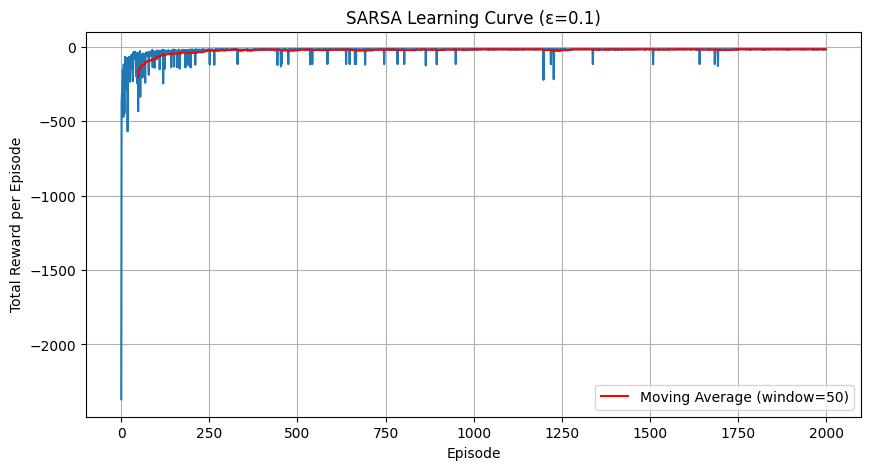

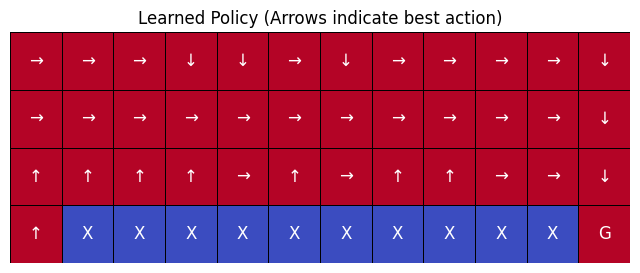

In [11]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# 创建 CliffWalking 环境
env = gym.make("CliffWalking-v0")

# 1. 初始化参数
alpha = 0.1       # 学习率
gamma = 0.99      # 折扣因子
epsilon = 0.1     # 探索率 (初始值)
epsilon_decay = 0.999 # (可选) Epsilon 衰减率
min_epsilon = 0.01   # (可选) 最小 Epsilon
num_episodes = 2000

# 初始化 Q 表 (状态是离散的数字 0-47)
# Q = defaultdict(lambda: np.zeros(env.action_space.n))
# 使用 numpy 数组更高效
Q = np.zeros((env.observation_space.n, env.action_space.n))

# 记录每回合奖励，用于观察学习过程
episode_rewards = []

# 2. ε-Greedy 策略函数
def choose_action_epsilon_greedy(state, current_epsilon):
    if np.random.rand() < current_epsilon:
        return env.action_space.sample() # 探索：随机选择动作
    else:
        # 利用：选择 Q 值最大的动作 (如果 Q 值相同，随机选一个)
        q_values = Q[state, :]
        max_q = np.max(q_values)
        # 找出所有具有最大 Q 值的动作的索引
        # 添加一个小的检查，防止所有Q值都是0的情况（在早期可能发生）
        if np.all(q_values == q_values[0]):
             return env.action_space.sample()
        best_actions = np.where(q_values == max_q)[0]
        return np.random.choice(best_actions)

# 3. SARSA 主循环
current_epsilon = epsilon
for i in range(num_episodes):
    state, info = env.reset()
    action = choose_action_epsilon_greedy(state, current_epsilon)
    terminated = False
    truncated = False
    total_reward = 0

    while not (terminated or truncated):
        # 执行动作，观察 S', R
        next_state, reward, terminated, truncated, info = env.step(action)

        # 在 S' 选择下一个动作 A' (根据当前策略)
        next_action = choose_action_epsilon_greedy(next_state, current_epsilon)

        # SARSA 更新
        # td_target = reward + gamma * Q[next_state, next_action] * (1 - terminated) # 如果终止，未来价值为0
        td_target = reward + gamma * np.max(Q[next_state, :]) * (1 - terminated) # 如果终止，未来价值为0
        td_error = td_target - Q[state, action]
        Q[state, action] = Q[state, action] + alpha * td_error

        state = next_state
        action = next_action
        total_reward += reward

    episode_rewards.append(total_reward)

    # (可选) Epsilon 衰减
    current_epsilon = max(min_epsilon, current_epsilon * epsilon_decay)

    if (i + 1) % 100 == 0:
        print(f"Episode {i+1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {current_epsilon:.3f}")


# 4. 可视化学习过程 (奖励曲线)
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards)
# 平滑处理，看得更清楚
# 使用 pandas 进行移动平均计算更方便
try:
    import pandas as pd
    moving_avg = pd.Series(episode_rewards).rolling(window=50).mean() # 计算50个周期的移动平均
    plt.plot(moving_avg, label='Moving Average (window=50)', color='red')
    plt.legend()
except ImportError:
    print("Pandas not installed, skipping moving average plot.")

plt.xlabel("Episode")
plt.ylabel("Total Reward per Episode")
plt.title(f"SARSA Learning Curve (ε={epsilon})")
plt.grid(True)
plt.show()

# 5. 可视化最终策略 (可选)
# 可以创建一个网格，用箭头表示每个状态下 Q 值最大的动作
def plot_policy(Q_table, env_shape=(4, 12)):
    policy_grid = np.empty(env_shape, dtype=str)
    actions_map = {0: '↑', 1: '→', 2: '↓', 3: '←'} # 上右下左

    for r in range(env_shape[0]):
        for c in range(env_shape[1]):
            state = r * env_shape[1] + c
            # CliffWalking-v0: 37-46 are cliff states, 47 is goal
            if 37 <= state <= 46:
                policy_grid[r, c] = 'X' # Cliff
                continue
            if state == 47:
                policy_grid[r, c] = 'G' # Goal
                continue
            if state == 36: # Start state
                 policy_grid[r, c] = 'S'


            # Check if Q-values for this state are all zero (might happen early on)
            if np.all(Q_table[state, :] == 0):
                 # Assign a default action or symbol if Q-values are zero and not cliff/goal/start
                 if policy_grid[r, c] == '': # Avoid overwriting S, G, X
                    policy_grid[r, c] = '.' # Indicate unvisited or zero Q
            else:
                best_action = np.argmax(Q_table[state, :])
                policy_grid[r, c] = actions_map[best_action]


    plt.figure(figsize=(8, 3))
    # Create a dummy data array for heatmap background coloring if needed
    dummy_data = np.zeros(env_shape)
    # Mark cliff states for potential background coloring
    dummy_data[3, 1:-1] = -1 # Example: mark cliff row with -1

    sns.heatmap(dummy_data, annot=policy_grid, fmt="", cmap="coolwarm", # Use a cmap that distinguishes cliff
                cbar=False, linewidths=.5, linecolor='black', annot_kws={"size": 12})
    plt.title("Learned Policy (Arrows indicate best action)")
    plt.xticks([])
    plt.yticks([])
    plt.show()

plot_policy(Q)


env.close()

In [7]:
epsilon

0.5